In [1]:
import os
import h5py
import numpy as np

from astropy.table import Table, Column
from astropy.io import fits

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patches as patches
import seaborn as sns

from desisim.io import read_basis_templates
from desisim.templates import BGS

sns.set(style='white', font_scale=1.3, palette='deep')
col = sns.color_palette()

%matplotlib inline

ImportError: No module named 'seaborn'

In [2]:
import seaborn

ImportError: No module named 'seaborn'

In [2]:
# Read the mock catalog, which is limited to r_SDSS<20.
catfile = 'BGS_r20.0_new_footprint.hdf5'
#catfile = 'galaxy_catalogue_0.hdf5'
#catfile = 'galaxy_catalogue_small.hdf5'
cat = h5py.File(catfile)
cat['Data'].values()

zobs1 = cat['Data/z_obs'][...]
rmabs1 = cat['Data/abs_mag'][...]
gr1 = cat['Data/g_r'][...]
rmag1 = cat['Data/app_mag'][...]

print('Read {} galaxies in catalog {}'.format(len(rmabs1), catfile))
cat.close()

Read 21029415 galaxies in catalog BGS_r20.0_new_footprint.hdf5


In [3]:
# Grab a subset of the galaxies and pull out their redshifts, apparent magnitudes, and 
# rest-frame colors and magnitudes.  All bands are SDSS, the rest-frame bands are
# band-shifted to z=0.1, and the absolute magnitude is for h=1.
seed = 456
ngal = 10000
rand = np.random.RandomState(seed)
these = rand.randint(0, len(rmabs1)+1, ngal)
rmabs = rmabs1[these]
gr = gr1[these]
rmag = rmag1[these]
zobs = zobs1[these]

In [4]:
# Read the BGS template metadata table.
_flux, wave, _meta = read_basis_templates('BGS')
print(_flux.shape)

INFO:io.py:611:read_basis_templates: Reading /Users/ioannis/research/projects/desi/spectro/templates/basis_templates/v2.3/bgs_templates_v2.1.fits
(7636, 41816)


In [5]:
# Restrict the AGES/BGS templates to r_SDSS<20 to match the mock.
keep = np.where(_meta['SDSS_UGRIZ_SYNTH'][:, 2] < 20.0)[0]
meta = _meta[keep]
flux = _flux[keep, :]
nbgs = len(meta)
print('Read {} AGES/BGS templates.'.format(nbgs))

Read 6352 AGES/BGS templates.


In [6]:
# Grab the absolute r-band magnitude (h=1) and g-r color (both band-shifted to z=0.1) of the models.
zobs_ages = meta['Z'].data
rmag_ages = meta['SDSS_UGRIZ_SYNTH'][:, 2].data
mabs_ages = meta['SDSS_UGRIZ_ABSMAG_Z01'].data
rmabs_ages = mabs_ages[:, 2]
gr_ages = mabs_ages[:, 1] - mabs_ages[:, 2]
weight_ages = meta['WEIGHT'].data

(0, 10)

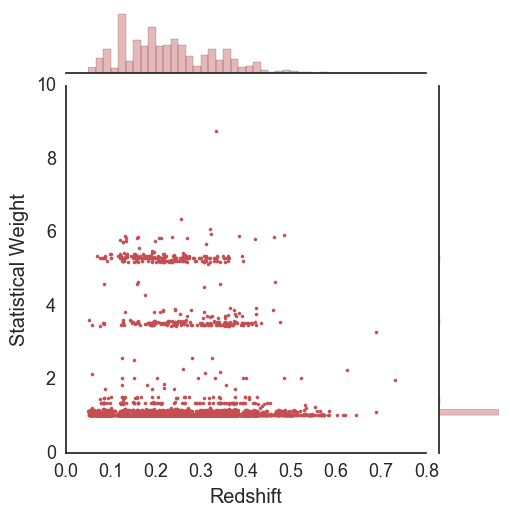

In [7]:
# The AGES/BGS models come with statistical weights so we can reconstruct 
# a flux-limited (I_AB<20.45 sample).  Visualize those weights here.
sns.jointplot(zobs_ages, weight_ages, stat_func=None, s=5, color=col[2], 
              size=5).set_axis_labels('Redshift', 'Statistical Weight')
plt.ylim(0, 10)

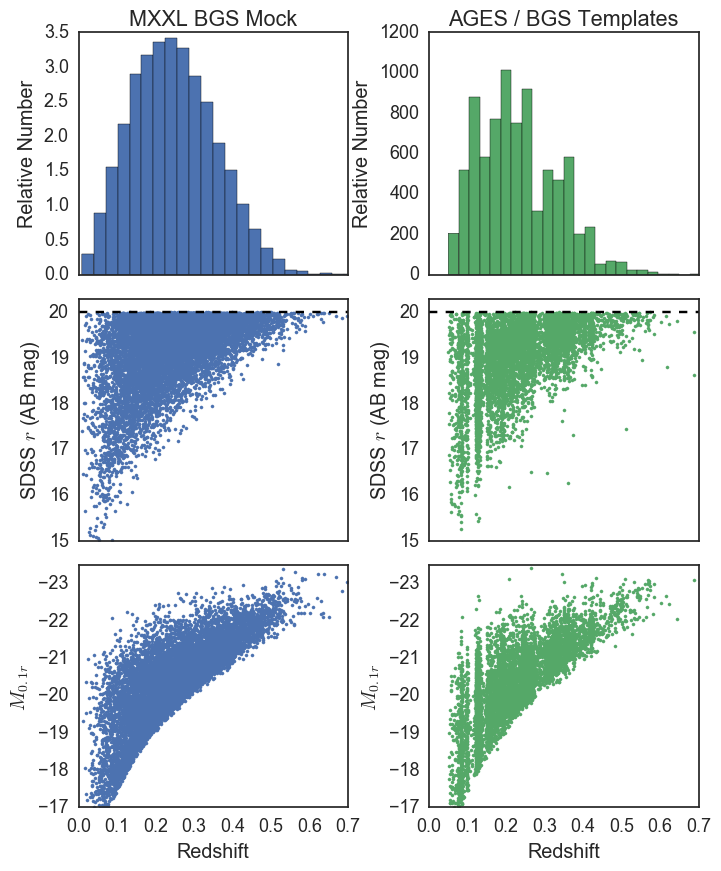

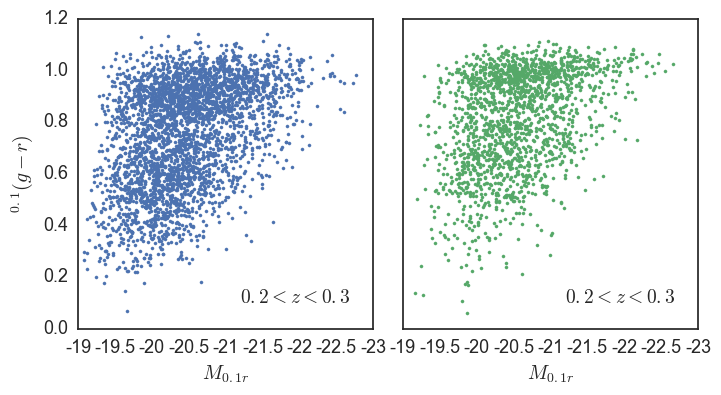

In [8]:
# Compare the mocks and the AGES/BGS templates side-by-side.
zrange = (0, 0.7)

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(8, 10), sharex=True)

_, _, _ = ax1.hist(zobs, bins=25, normed=True, color=col[0])
ax1.set_title('MXXL BGS Mock')
ax1.set_ylabel('Relative Number')
ax1.set_xlim(zrange)

_, _, _ = ax2.hist(zobs_ages, bins=25, color=col[1], weights=weight_ages)
ax2.set_title('AGES / BGS Templates')
ax2.set_ylabel('Relative Number')
ax2.set_xlim(zrange)

ax3.scatter(zobs, rmag, s=5, color=col[0])
ax3.axhline(20, ls='--', color='k')
ax3.set_ylabel('SDSS $r$ (AB mag)')
ax3.set_ylim(15, 20.3)
ax3.set_xlim(zrange)

ax4.scatter(zobs_ages, rmag_ages, s=5, color=col[1])
ax4.axhline(20, ls='--', color='k')
ax4.set_ylabel('SDSS $r$ (AB mag)')
ax4.set_ylim(15, 20.3)
ax4.set_xlim(zrange)

ax5.scatter(zobs, rmabs, s=5, color=col[0])
ax5.set_ylabel('$M_{0.1r}$')
ax5.set_xlabel('Redshift')
ax5.set_ylim(-17, -23.5)
ax5.set_xlim(zrange)

ax6.scatter(zobs_ages, rmabs_ages, s=5, color=col[1])
ax6.set_ylabel('$M_{0.1r}$')
ax6.set_xlabel('Redshift')
ax6.set_ylim(-17, -23.5)
ax6.set_xlim(zrange)
fig.subplots_adjust(wspace=0.3, hspace=0.1)


fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(8, 4), sharey=True)
these = np.where((zobs > 0.2)*(zobs < 0.3))[0]
ax1.scatter(rmabs[these], gr[these], s=5, color=col[0])
ax1.set_ylabel('$^{0.1}(g -r)$')
ax1.set_xlabel('$M_{0.1r}$')
ax1.set_xlim(-19, -23)
ax1.set_ylim(0.0, 1.2)
ax1.xaxis.set_major_formatter(ticker.FormatStrFormatter('%g'))
ax1.text(-22.7, 0.1, r'$0.2 < z < 0.3$', ha='right', fontsize=14)

these = np.where((zobs_ages > 0.2)*(zobs_ages < 0.3))[0]
ax2.scatter(rmabs_ages[these], gr_ages[these], s=5, color=col[1])
ax2.set_xlabel('$M_{0.1r}$')
ax2.set_xlim(-19, -23)
ax2.set_ylim(0.0, 1.2)
ax2.xaxis.set_major_formatter(ticker.FormatStrFormatter('%g'))
ax2.text(-22.7, 0.1, r'$0.2 < z < 0.3$', ha='right', fontsize=14)
fig.subplots_adjust(wspace=0.1)

In [9]:
# For each mock galaxy, find the set of AGES/BGS templates within a given "distance" (cube) in 
# the three-dimensional redshift-absolute magnitude-color space.  If no templates are in that box,
# simply choose the closest one.
def get_close_templates(zobs, zobs_ages, rmabs, rmabs_ages, gr, gr_ages, 
                       dzmin=0.05, drmabsmin=0.1, dgrmin=0.05):

    dz = zobs[:, None] - zobs_ages[None, :]
    drmabs = rmabs[:, None] - rmabs_ages[None, :]
    dgr = gr[:, None] - gr_ages[None, :]

    close = ((np.abs(dz) < dzmin) * 
             (np.abs(drmabs) < drmabsmin) * 
             (np.abs(dgr) < dgrmin)) * 1

    noneclose = np.where(np.sum(close, axis=1) == 0)[0]
    if len(noneclose) > 0:
        dist = np.sqrt(dz**2 + drmabs**2 + dgr**2)
        nearest = np.argmin(dist[noneclose, :], axis=1)
        close[noneclose, nearest] = 1
    #print(np.where(np.sum(close, axis=1) == 0)) # check we did it right
    
    return close

In [10]:
# For each mock galaxy, choose a "nearby" AGES/BGS template taking into account the relative 
# weight of each template (i.e., choose a spectrum with the correct probability).
def get_nearest_template(close, weight):
    '''
      Args:
        close - [nmock, nbgs] array
        weight - [nbgs] array
    '''
    ngal, nbgs = np.shape(close)
    bigweight = np.repeat(weight_ages, ngal).reshape(ngal, nbgs)
    normweight = bigweight * close / np.repeat(np.sum(bigweight * close, axis=1), nbgs).reshape(ngal, nbgs)
    cumprob = np.cumsum(normweight, axis=1)
    thresh = rand.random_sample(ngal)
    bigindx = (cumprob > np.repeat(thresh, nbgs).reshape(ngal, nbgs)) * (cumprob > 0) * 1

    # There's gotta be a way to do this without looping!
    indx = np.zeros(ngal).astype('i4')
    for ii in range(ngal):
        indx[ii] = np.where(bigindx[ii, :] == 1)[0][0]
    return indx

close = get_close_templates(zobs, zobs_ages, rmabs, rmabs_ages, gr, gr_ages)
indx = get_nearest_template(close, weight_ages)

In [26]:
def qa_nearby_colormag(_this=0, ax=None, verbose=False):
    if ax is None:
        fig, ax = plt.subplots(figsize = (5, 4))
    
    _these = np.where(close[_this, :] == 1)[0]
    _zclose = np.where(np.abs(zobs[_this] - zobs_ages) < 0.05)[0]
    if len(_zclose) == 0:
        _zclose = np.where(np.abs(zobs[_this] - zobs_ages) < 2*0.05)[0]
 
    if verbose:
        print(zobs[_this], rmabs[_this], gr[_this])
        print(zobs_ages[_these])
        print(rmabs_ages[_these])
        print(gr_ages[_these])
    
    ax.scatter(rmabs_ages[_zclose], gr_ages[_zclose], s=5, alpha=0.5, 
               color='lightgray', label='All Templates')
    ax.scatter(rmabs_ages[_these], gr_ages[_these], s=5, 
               color='tan', label='"Near" Templates')
    ax.scatter(rmabs[_this], gr[_this], s=5, color='k', label='Mock Galaxy')
    ax.add_patch(
        patches.Rectangle((rmabs[_this] - 0.1, gr[_this] - 0.05),
                          2*0.1, 2*0.05, fill=False, edgecolor='k', lw=1))

    zmin, zmax = '{:.3f}'.format(zobs[_this] - 0.05), '{:.3f}'.format(zobs[_this] + 0.05)
    mrmin = rmabs[_this] + 1.5
    if mrmin > -17:
        mrmin = -17
    #ax.set_xlim(mrmin, -23)
    ax.set_xlim(-19.5, -23)
    ax.set_ylim(0.0, 1.3)
    ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%g'))
    ax.text(-22.7, 1.15, r'${} < z < {}$'.format(zmin, zmax), ha='right', fontsize=12)

In [27]:
def qa_nearby_templates(_this=0, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize = (5, 4))
        
    def _normalize(__wave, __flux, wnorm=5500.0):
        return __flux / np.interp(wnorm, __wave, __flux)         
        
    _these = np.where(close[_this, :] == 1)[0]
    
    #ax.plot(wave, _normalize(wave, np.min(flux[_these, :], axis=0)), color='lightgray')
    #ax.plot(wave, _normalize(wave, np.max(flux[_these, :], axis=0)), color='lightgray')
    for ii in _these:
        ax.plot(wave, _normalize(wave, flux[ii, :]), color='tan')
    ax.plot(wave, _normalize(wave, flux[indx[_this], :]), color='k', alpha=0.5)
    ax.set_xlim(3000, 9800)
    ax.set_ylim(0.0, 1.9)
    ax.text(9500, 1.65, r'$N = {}$'.format(len(_these)), ha='right', fontsize=12)
    ax.text(9500, 1.45, r'$M_{{0.1r}} = {:.2f}$'.format(rmabs[this]), ha='right', fontsize=12)
    ax.text(9500, 1.25, r'$^{{0.1}}(g - r) = {:.3f}$'.format(gr[this]), ha='right', fontsize=12)

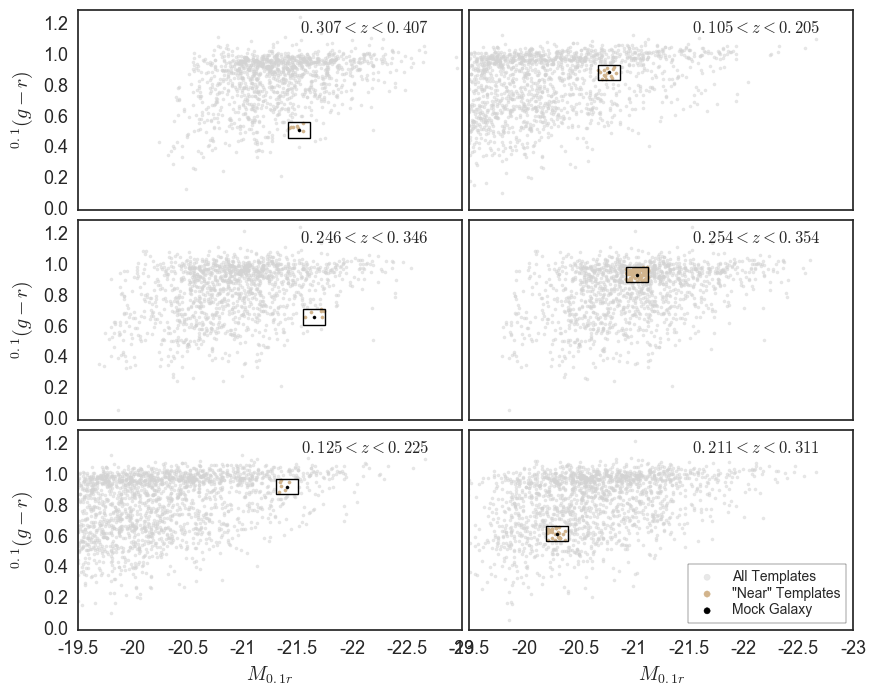

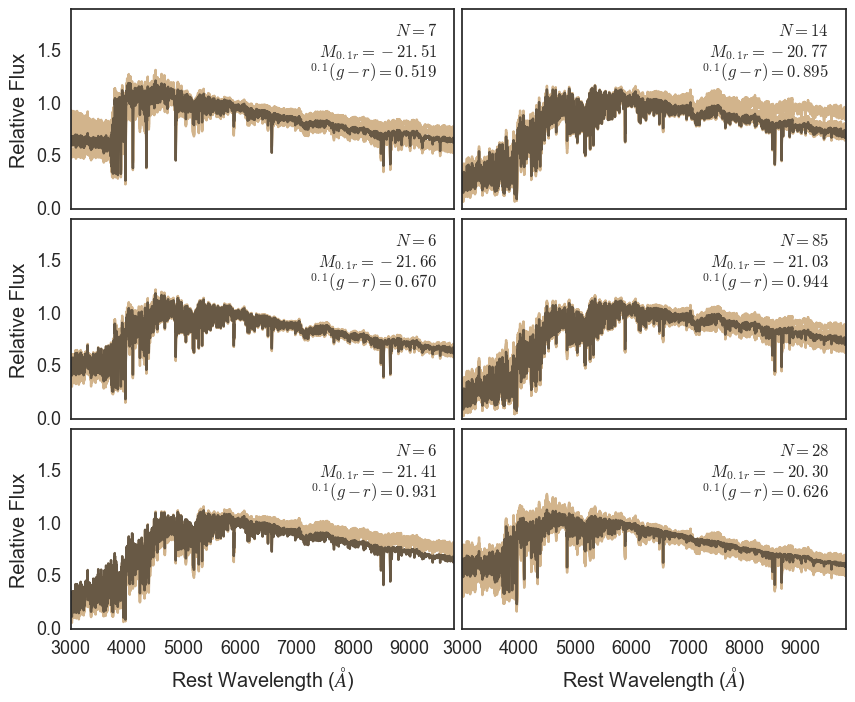

In [28]:
# Spot-check that for a given mock "galaxy" we have chosen good matching AGES/BGS templates.
# this = 280
nshow = 6
cut = np.where((rmabs < -20) * (rmabs > -22.5) * (zobs < 0.4))[0]
these = rand.choice(cut, size=nshow)
fig, allax = plt.subplots(3, 2, figsize = (10, 8), sharex=True, sharey=True)
for this, ax in zip(these, allax.flat):
    qa_nearby_colormag(this, ax)
allax[2, 0].set_xlabel('$M_{0.1r}$')
allax[2, 1].set_xlabel('$M_{0.1r}$')
allax[0, 0].set_ylabel('$^{0.1}(g -r)$')
allax[1, 0].set_ylabel('$^{0.1}(g -r)$')
allax[2, 0].set_ylabel('$^{0.1}(g -r)$')
allax[2, 1].legend(loc='lower right', fontsize=10, frameon=True, markerscale=2, labelspacing=0.2)
fig.subplots_adjust(wspace=0.02, hspace=0.05)

fig, allax = plt.subplots(3, 2, figsize = (10, 8), sharex=True, sharey=True)
for this, ax in zip(these, allax.flat):
    qa_nearby_templates(this, ax)
allax[2, 0].set_xlabel('Rest Wavelength ($\AA$)')
allax[2, 1].set_xlabel('Rest Wavelength ($\AA$)')
allax[0, 0].set_ylabel('Relative Flux')
allax[1, 0].set_ylabel('Relative Flux')
allax[2, 0].set_ylabel('Relative Flux')
fig.subplots_adjust(wspace=0.02, hspace=0.05)


In [19]:
# Time how long it takes to select spectra for all the mock galaxies.
%time allclose = get_close_templates(zobs, zobs_ages, rmabs, rmabs_ages, gr, gr_ages)
%time allindx = get_nearest_template(allclose, weight_ages)

CPU times: user 1.52 s, sys: 1.91 s, total: 3.43 s
Wall time: 4.14 s
CPU times: user 3.08 s, sys: 1.7 s, total: 4.78 s
Wall time: 4.8 s
